In [76]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import Polygon, MultiPolygon, box
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox 
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch, Circle
import matplotlib.ticker as mticker
import sklearn
import importlib
import cartopy.crs as ccrs
import cartopy as ctp
from cmcrameri import cm

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_plotting = os.path.join(folder_HMA, 'Plotting')
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')

# open rgi
path_rgi = os.path.join(folder_HMA, 'Datasets', "AOI definition", "Final AOI", "final Products", "AOI_full_rgi.shp")
path_dc = os.path.join(folder_HMA, 'Datasets', "AOI definition", "Final AOI", "final Products", "AOI_dc_rgi.shp")
rgi_gdf = gpd.read_file(path_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(path_dc).to_crs("ESRI:102025")

# open the subregion df
path_o1 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o1regions.shp")
path_o2 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o2regions.shp")
o1_gdf = gpd.read_file(path_o1).to_crs("ESRI:102025")
o2_gdf_all = gpd.read_file(path_o2).to_crs("ESRI:102025")

# subset to the HMA regions
o1_gdf = o1_gdf[o1_gdf['o1region'].isin(["13","14","15"])]
o2_gdf = o2_gdf_all[o2_gdf_all['o2region'].isin(rgi_gdf['o2region'])].copy() # only get o2regions with our glaciers

In [3]:
# add color column to o2_gdf, based on o1region
colors = []
for idx,row in o2_gdf.iterrows():
    if row['o1region']=='13': colors.append('tab:green')
    elif row['o1region']=='14': colors.append('blue')
    elif row['o1region']=='15': colors.append('tab:red')
o2_gdf['colors']=colors

In [4]:
# opening a Natural Earth background
path_background = os.path.join(folder_plotting, 'NE1_HR_LC', "NE1_HR_LC_projected.tif")
background_im = riox.open_rasterio(path_background)

path_background2 = os.path.join(folder_plotting, 'NE1_HR_LC', "NE1_HR_LC_shean_aee.tif")
background_im2 = riox.open_rasterio(path_background2)

# clip to main extent
xlims = (-2500000, 1000000)
ylims = (-700000, 2000000)
background_im = background_im.sel(x=slice(xlims[0]-2000,xlims[1]+2000), y=slice(ylims[1]+2000, ylims[0]-2000))

xlims2 = (-1700000,2000000)
ylims2 = (-1100000,1000000)
background_im2 = background_im2.sel(x=slice(xlims2[0]-2000,xlims2[1]+2000), y=slice(ylims2[1]+2000, ylims2[0]-2000))


In [5]:
# open rivers and lakes and countries etc
path_rivers = os.path.join(folder_plotting, 'ne_10m_rivers_lake_centerlines', "ne_10m_rivers_lake_centerlines.shp")
path_lakes = os.path.join(folder_plotting, 'ne_10m_lakes', "ne_10m_lakes.shp")
path_countries = os.path.join(folder_plotting, 'ne_10m_admin_0_boundary_lines_land', "ne_10m_admin_0_boundary_lines_land.shp")
path_cities = os.path.join(folder_plotting, "ne_10m_populated_places_simple", "ne_10m_populated_places_simple.shp")
rivers_gdf = gpd.read_file(path_rivers).to_crs("ESRI:102025")
lakes_gdf = gpd.read_file(path_lakes).to_crs("ESRI:102025")
countries_gdf = gpd.read_file(path_countries).to_crs("ESRI:102025")
cities_gdf = gpd.read_file(path_cities).to_crs("ESRI:102025")

In [6]:
big_cities = ["Kathmandu", "Lhasa", "Thimphu", "New Delhi", 'Islamabad', 'Almaty', 'Kashgar']
big_cities_gdf = cities_gdf[cities_gdf['name'].isin(big_cities)]

In [7]:
# define esri:102025 projection for cartopy
projection_esri = ccrs.AlbersEqualArea(central_longitude=95.0, central_latitude=30,
                            false_easting=0.0, false_northing=0.0,
                            standard_parallels=(15.0, 65.0), globe=None)

# define hma-specific alber equal area (from david shean)
projection_shean = ccrs.AlbersEqualArea(central_longitude=85.0, central_latitude=36,
                            false_easting=0.0, false_northing=0.0,
                            standard_parallels=(25.0, 47.0), globe=None)

# other matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [8]:
# open the water data for each glacier, format into a single df
c=0
all_series = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>10: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list   
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_binary_otsuoptimal_188_binned4_accaqa.csv')
    
    df_g = pd.read_csv(path_open, index_col=0, header=None).squeeze()
    all_series.append(df_g)

# format into df
df_all = pd.DataFrame(all_series).reset_index(drop=True)

# format to numeric dtypes
all_cols = df_all.columns
for c in all_cols:
    if c in ['rgi_id', 'o1_region', 'o2_region']: continue
    df_all[c] = df_all[c].astype(float)

# add extra columns on for each glacier (dc area, etc...)
df_all = df_all.merge(dc_gdf[['rgi_id','area_dc','cenlon','cenlat']], on='rgi_id')

# merge with glacier area
print("All done!")


100 of 769 RGI2000-v7.0-G-13-24023
200 of 769 RGI2000-v7.0-G-14-01890
300 of 769 RGI2000-v7.0-G-14-19825
400 of 769 RGI2000-v7.0-G-14-30996
500 of 769 RGI2000-v7.0-G-15-01541
600 of 769 RGI2000-v7.0-G-15-05619
700 of 769 RGI2000-v7.0-G-15-09257
All done!


In [9]:
# reproject rgi cenlon/cenlat to hma alaska albers
hma_point = gpd.points_from_xy(df_all['cenlon'], df_all['cenlat'], crs='EPSG:4326') \
                    .to_crs(projection_shean.proj4_init)
df_all['x_hma'] = [p.x for p in hma_point]
df_all['y_hma'] = [p.y for p in hma_point]

In [171]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values

# create subsets of lake terminating vs non-lake terminating so we can compare
df_all_lt = df_all[df_all['rgi_id'].isin(rgi_lake_term)]
df_all_nlt = df_all[~df_all['rgi_id'].isin(rgi_lake_term)]
# rgi_lake_term

5.341704503454429


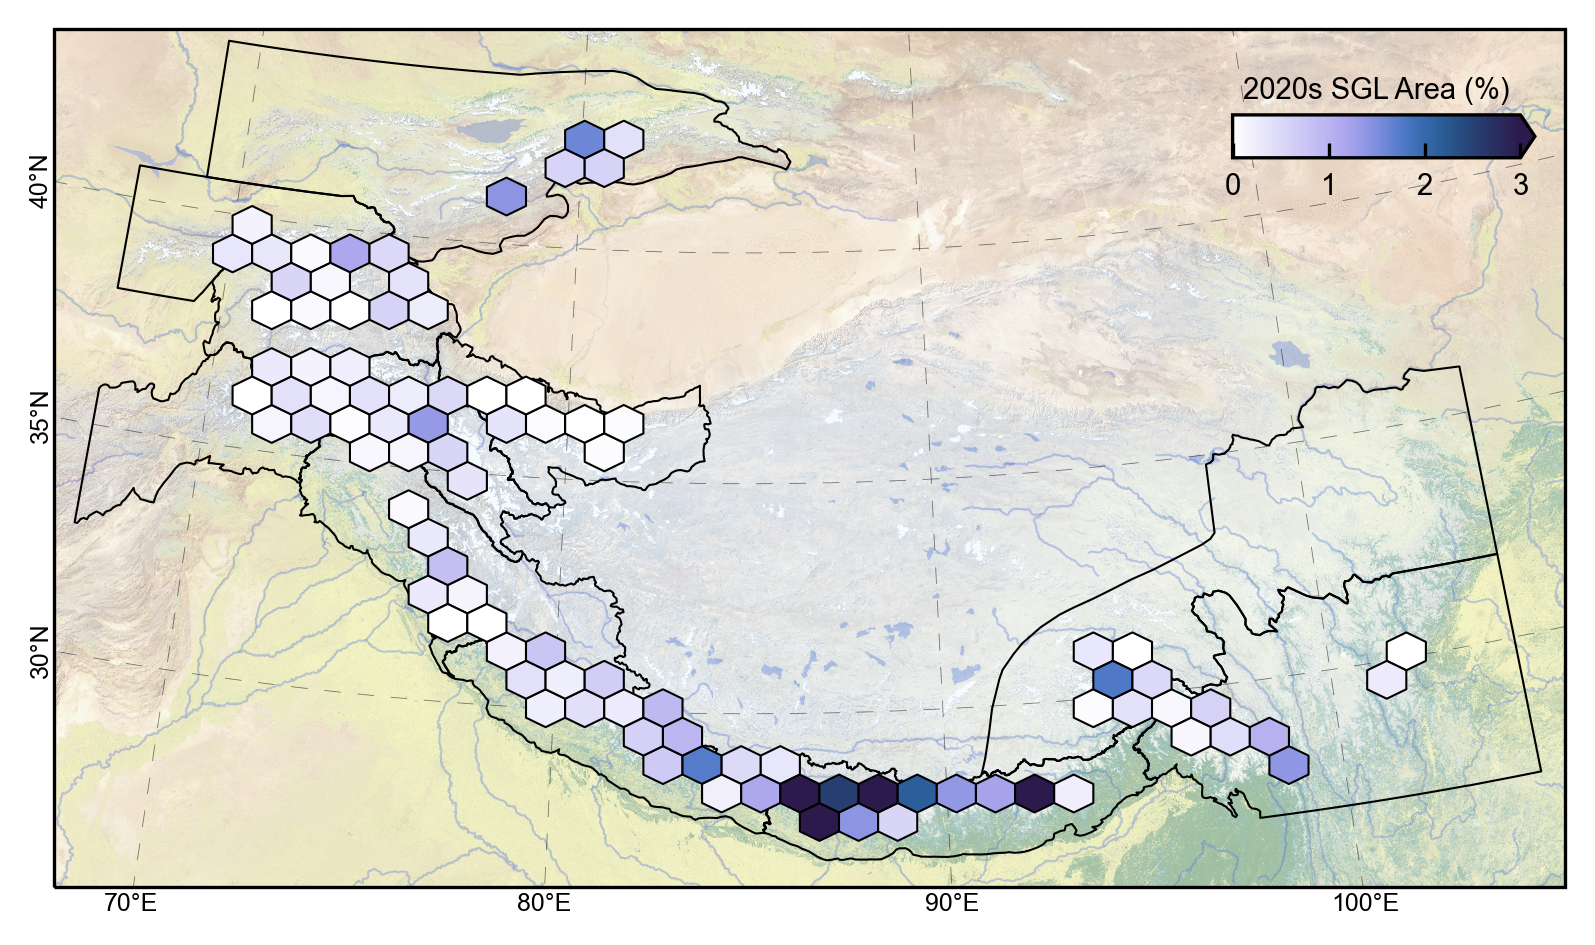

In [177]:
### sgl cover in the 2020s
x_bins = df_all_nlt['x_hma']
y_bins = df_all_nlt['y_hma']
gridsize=(30,12)


fig,axs = plt.subplots(figsize=(6.5,4), dpi=300, subplot_kw={'projection':projection_shean})

# background image
background_im2.plot.imshow(rgb='band', ax=axs, zorder=1)

# countries
# countries_gdf.plot(ax=axs, edgecolor='gray', linestyle='dashed', facecolor='none', linewidth=0.5,
#                    transform=projection_esri, zorder=2)

# rivers and lakes
watercolor = 'royalblue'
rivers_gdf.plot(ax=axs, color=watercolor, linewidth=0.5, alpha=0.3, transform=projection_esri, zorder=2)
lakes_gdf.plot(ax=axs, color=watercolor, linewidth=0.5, alpha=0.3, transform=projection_esri, zorder=2)

# o2region boundaries, adding colors along the way
# o2_gdf.plot(ax=axs, edgecolor='none', color=o2_gdf['colors'], alpha=0.2,
#                     transform=projection_esri, zorder=3)
o2_gdf.boundary.plot(ax=axs, edgecolor='black', facecolor='none', linewidth=0.5,
                     transform=projection_esri, zorder=3)

# glaciers
# rgi_gdf.plot(ax=axs, color='indigo', edgecolor='indigo', linewidth=1, transform=projection_esri, zorder=11)

### hexbins for total dc area
hba = axs.hexbin(x_bins, y_bins, C=df_all_nlt['area_dc']*1000*1000, gridsize=gridsize,reduce_C_function=np.nansum, alpha=0)

### hexbins for 1990s, 2020s
hb20 = axs.hexbin(x_bins, y_bins, C=df_all_nlt[['water_2020_m2','water_2021_m2','water_2022_m2','water_2023_m2']].mean(axis=1),
                 gridsize=gridsize, reduce_C_function=np.nansum,
                 vmin=0, vmax=3, cmap=cm.devon_r, zorder=10, edgecolor='black', linewidth=0.5)
print(np.nanmax(hb20.get_array()/hba.get_array()*100))
hb20.set_array(hb20.get_array()/hba.get_array()*100)

# add inset axis for colorbar
cbax = axs.inset_axes( (0.78, 0.85, 0.2, 0.05))
plt.colorbar(hb20, cax=cbax, orientation="horizontal", extend='max')
cbax.tick_params(axis="both",direction="in")
cbax.set_xticks([0,1,2,3],[0,1,2,3], fontsize=7)
cbax.set_title("2020s SGL Area (%)", fontsize=7, pad=4)


# # axis limits, etc
axs.set_xlim(xlims2)
axs.set_ylim(ylims2)
axs.set_title("")

# # add lat/lon gridlines
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ypadding=3, xpadding=4,
              linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5, zorder=2)

# gridline edits
gl.top_labels=False
gl.right_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([70, 80, 90, 100])
gl.ylocator = mticker.FixedLocator([30, 35, 40])

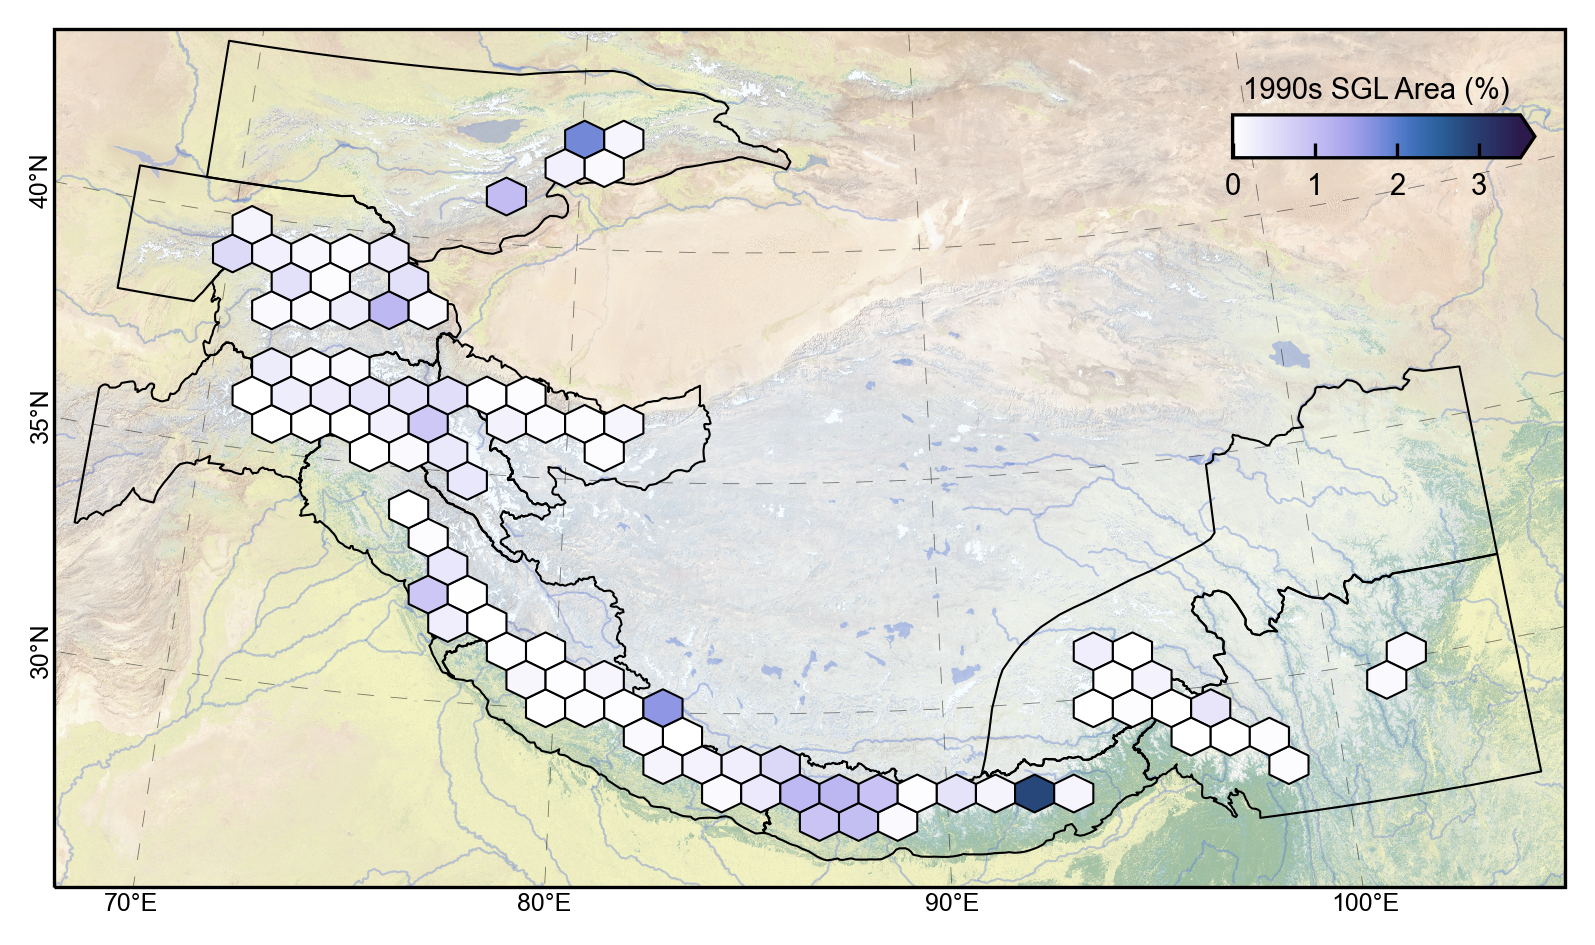

In [176]:
### sgl cover in the 2020s
x_bins = df_all_nlt['x_hma']
y_bins = df_all_nlt['y_hma']
gridsize=(30,12)


fig,axs = plt.subplots(figsize=(6.5,4), dpi=300, subplot_kw={'projection':projection_shean})

# background image
background_im2.plot.imshow(rgb='band', ax=axs, zorder=1)

# countries
# countries_gdf.plot(ax=axs, edgecolor='gray', linestyle='dashed', facecolor='none', linewidth=0.5,
#                    transform=projection_esri, zorder=2)

# rivers and lakes
watercolor = 'royalblue'
rivers_gdf.plot(ax=axs, color=watercolor, linewidth=0.5, alpha=0.3, transform=projection_esri, zorder=2)
lakes_gdf.plot(ax=axs, color=watercolor, linewidth=0.5, alpha=0.3, transform=projection_esri, zorder=2)

# o2region boundaries, adding colors along the way
# o2_gdf.plot(ax=axs, edgecolor='none', color=o2_gdf['colors'], alpha=0.2,
#                     transform=projection_esri, zorder=3)
o2_gdf.boundary.plot(ax=axs, edgecolor='black', facecolor='none', linewidth=0.5,
                     transform=projection_esri, zorder=3)

# glaciers
# rgi_gdf.plot(ax=axs, color='indigo', edgecolor='indigo', linewidth=1, transform=projection_esri, zorder=11)

### hexbins for total dc area
hba = axs.hexbin(x_bins, y_bins, C=df_all_nlt['area_dc']*1000*1000, gridsize=gridsize,reduce_C_function=np.nansum, alpha=0)

### hexbins for 1990s, 2020s
hb90 = axs.hexbin(x_bins, y_bins, C=df_all_nlt[['water_1988_m2','water_1992_m2','water_1994_m2','water_1996_m2','water_1998_m2']].mean(axis=1),
                 gridsize=gridsize, reduce_C_function=np.nansum,
                 vmin=0, vmax=3.5, cmap=cm.devon_r, zorder=10, edgecolor='black', linewidth=0.5)
hb90.set_array(hb90.get_array()/hba.get_array()*100)

# add inset axis for colorbar
cbax = axs.inset_axes( (0.78, 0.85, 0.2, 0.05))
plt.colorbar(hb90, cax=cbax, orientation="horizontal", extend='max')
cbax.tick_params(axis="both",direction="in")
cbax.set_xticks([0,1,2,3],[0,1,2,3], fontsize=7)
cbax.set_title("1990s SGL Area (%)", fontsize=7, pad=4)


# # axis limits, etc
axs.set_xlim(xlims2)
axs.set_ylim(ylims2)
axs.set_title("")

# # add lat/lon gridlines
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ypadding=3, xpadding=4,
              linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5, zorder=2)

# gridline edits
gl.top_labels=False
gl.right_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([70, 80, 90, 100])
gl.ylocator = mticker.FixedLocator([30, 35, 40])

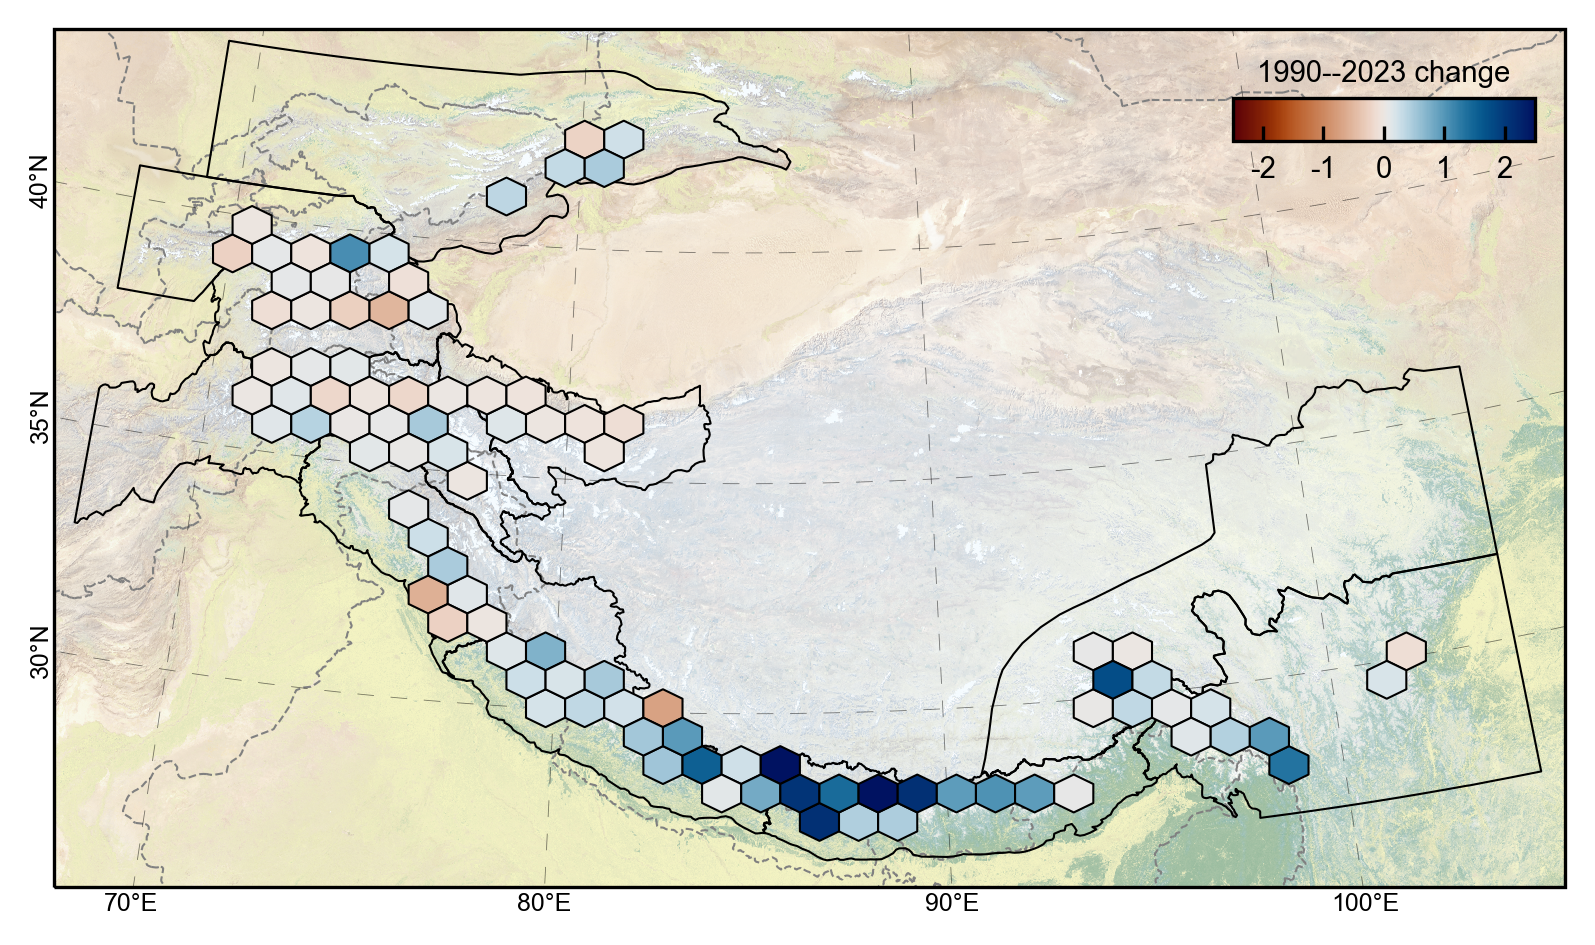

In [162]:
### sgl cover change between 1990s and 2020s
x_bins = df_all_nlt['x_hma']
y_bins = df_all_nlt['y_hma']
gridsize=(30,12)

fig,axs = plt.subplots(figsize=(6.5,4), dpi=300, subplot_kw={'projection':projection_shean})

# background image
background_im2.plot.imshow(rgb='band', ax=axs, zorder=1)

# countries
countries_gdf.plot(ax=axs, edgecolor='gray', linestyle='dashed', facecolor='none', linewidth=0.5,
                   transform=projection_esri, zorder=2)

# rivers and lakes
watercolor = 'royalblue'
# rivers_gdf.plot(ax=axs, color=watercolor, linewidth=0.5, alpha=0.3, transform=projection_esri, zorder=2)
# lakes_gdf.plot(ax=axs, color=watercolor, linewidth=0.5, alpha=0.3, transform=projection_esri, zorder=2)

# o2region boundaries, adding colors along the way
# o2_gdf.plot(ax=axs, edgecolor='none', color=o2_gdf['colors'], alpha=0.2,
#                     transform=projection_esri, zorder=3)
o2_gdf.boundary.plot(ax=axs, edgecolor='black', facecolor='none', linewidth=0.5,
                     transform=projection_esri, zorder=3)

# glaciers
# rgi_gdf.plot(ax=axs, color='indigo', edgecolor='indigo', linewidth=1, transform=projection_esri, zorder=11)

### hexbins for total dc area
hba = axs.hexbin(x_bins, y_bins, C=df_all_nlt['area_dc']*1000*1000, gridsize=gridsize,reduce_C_function=np.nansum, alpha=0)

### hexbins for 1990s, 2020s
hb20 = axs.hexbin(x_bins, y_bins, C=df_all_nlt[['water_2020_m2','water_2021_m2','water_2022_m2','water_2023_m2']].mean(axis=1),
                 gridsize=gridsize, reduce_C_function=np.nansum,
                 vmin=0, vmax=2, cmap=cm.lapaz_r, zorder=10, edgecolor='black', linewidth=0.5, alpha=0)
hb20.set_array(hb20.get_array()/hba.get_array()*100)

hb90 = axs.hexbin(x_bins, y_bins, C=df_all_nlt[['water_1988_m2','water_1992_m2','water_1994_m2','water_1996_m2','water_1998_m2']].mean(axis=1),
                 gridsize=gridsize, reduce_C_function=np.nansum,
                 vmin=-2.5, vmax=2.5, cmap=cm.vik_r, zorder=10, edgecolor='black', linewidth=0.5)
hb90.set_array(hb90.get_array()/hba.get_array()*100)

# calculate magnitude increase
hb90.set_array(hb20.get_array()-hb90.get_array())

# add inset axis for colorbar
cbax = axs.inset_axes( (0.78, 0.87 , 0.2, 0.05))
plt.colorbar(hb90, cax=cbax, orientation="horizontal")
cbax.tick_params(axis="both",direction="in")
cbax.set_xticks([-2,-1,0,1,2],[-2,-1,0,1,2], fontsize=7)
cbax.set_title("1990--2023 change", fontsize=7, pad=4)



# # axis limits, etc
axs.set_xlim(xlims2)
axs.set_ylim(ylims2)
axs.set_title("")

# # add lat/lon gridlines
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ypadding=3, xpadding=4,
              linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5, zorder=2)

# gridline edits
gl.top_labels=False
gl.right_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([70, 80, 90, 100])
gl.ylocator = mticker.FixedLocator([30, 35, 40])